In [1]:
import sys
import glob
import os
sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
from torch.utils.data import DataLoader

from satellite2map.datasets import Maps
from satellite2map.models.generator import UnetGenerator
from satellite2map.metricas import *
import satellite2map.transforms as T

from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pix2Pix evaluation

In [2]:
@dataclass
class hyperparameters:
    # training hyperparams
    n_epochs: int = 100
    batch_size: int = 32
    lr: float = 2e-3

hyperparams = hyperparameters()

## Loading data

In [3]:
transforms = T.Compose([T.Resize((256,256)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])
test_dataset = Maps(root='../data/mod', mode='test', transform=transforms, download=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [4]:
# for i, (sat, map) in enumerate(train_dataset):
#     i = i + 1
#     print(i, sat.shape, map.shape)

#     ax = plt.subplot(1, 4, i)
#     plt.tight_layout()
#     #ax.set_title('Satellite #{}'.format(i))
#     ax.axis('off')
#     sat = sat * 0.5 + 0.5
#     plt.imshow(sat.permute((1, 2, 0)).numpy())

#     ax = plt.subplot(2, 4, i)
#     plt.tight_layout()
#     #ax.set_title('Map #{}'.format(i))
#     ax.axis('off')
#     map = map * 0.5 + 0.5
#     plt.imshow(map.permute((1, 2, 0)).numpy())

#     if i == 4:
#         plt.show()
#         break

# Loading model

In [5]:
generator = UnetGenerator().to(DEVICE)
gen_state_dict = torch.load('../models/pix2pix/checkpoints/checkpoint_100.pth')['gen_weights']
generator.load_state_dict(gen_state_dict)

/tmp/ipykernel_57129/2862193365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_state_dict = torch.load('../models/pix2pix/checkpoints/checkpoint_100.pth')['gen_weig

<All keys matched successfully>

# Visualizing results

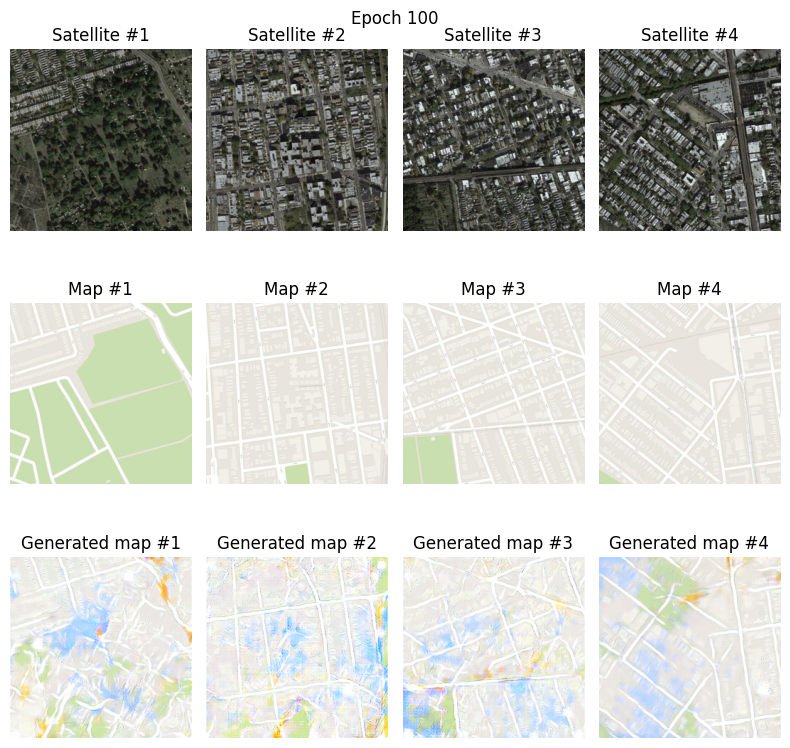

In [6]:
fig = plt.figure(figsize=(8, 8))
indexes = torch.randint(0, len(test_dataset), (4,))
for i in range(4):
    (sat, map) = test_dataset[indexes[i]]
    i = i + 1
    # print(i, sat.shape, map.shape)
    gen_map = generator(sat.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    # Sattelite (input)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title('Satellite #{}'.format(i))
    ax.axis('off')
    sat = sat * 0.5 + 0.5
    plt.imshow(sat.permute((1, 2, 0)).numpy())

    # Map (target)
    ax = fig.add_subplot(3, 4, i+4)
    ax.set_title('Map #{}'.format(i))
    ax.axis('off')
    map = map * 0.5 + 0.5
    plt.imshow(map.permute((1, 2, 0)).numpy())

    # Generated map (output)
    ax = fig.add_subplot(3, 4, i+8)
    ax.set_title('Generated map #{}'.format(i))
    ax.axis('off')
    gen_map = gen_map * 0.5 + 0.5
    plt.imshow(gen_map.permute((1, 2, 0)).cpu().detach().numpy())
    if i == 4:
        fig.tight_layout()
        fig.suptitle('Epoch 100')
        plt.show()
        break

# Calculating metrics

In [7]:
# sampling a random batch from validation dataset
sat_batch, map_batch = next(iter(test_dataloader))

# generating maps
gen_map_batch = generator(sat_batch)

# calculating metrics
mse = MSE(gen_map_batch, map_batch)
psnr = PSNR(gen_map_batch, map_batch)
ssim = SSIM(gen_map_batch, map_batch)
pa = PA(gen_map_batch, map_batch)
print(f'MSE: {mse}, PSNR: {psnr}, SSIM: {ssim}, PA: {pa}')

MSE: 0.0035594631917774677, PSNR: 72.61695861816406, SSIM: 0.570336103439331, PA: 0.5414462308271215
